## Absolute Prominence Task - Differential Entropy and Control functions 

In [1]:
from src.data.components.helsinki import HelsinkiProminenceExtractor
from src.data.components.datasets import TokenTaggingDataset
from torch.utils.data import DataLoader
from transformers import GPT2Tokenizer
import numpy as np
import os
from tqdm import tqdm

from src.utils.text_processing import python_lowercase_remove_punctuation
from src.utils.text_processing import get_wordlist_from_string

# only to create a valid dataset
dummy_tokenizer = GPT2Tokenizer.from_pretrained("gpt2", add_special_tokens=True)

/opt/homebrew/Caskroom/miniforge/base/envs/prosody/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load data

In [2]:
DATA_DIR = "/Users/lukas/Desktop/projects/MIT/MIT_prosody/data/Helsinki"
SAVE_DIR = "/Users/lukas/Desktop/projects/MIT/MIT_prosody/precomputed/predictions/emnlp/prominence_relative_mean"

In [3]:
train_extractor = HelsinkiProminenceExtractor(
    DATA_DIR,
    "train_360.txt",
)
train_texts = train_extractor.get_all_texts()
train_prominences = train_extractor.get_all_real_prominence()

dev_extractor = HelsinkiProminenceExtractor(
    DATA_DIR,
    "dev.txt",
)
dev_texts = dev_extractor.get_all_texts()
dev_prominences = dev_extractor.get_all_real_prominence()

test_extractor = HelsinkiProminenceExtractor(
    DATA_DIR,
    "test.txt",
)
test_texts = test_extractor.get_all_texts()
test_prominences = test_extractor.get_all_real_prominence()

print(
    f"train_texts: {len(train_texts)}, dev_texts: {len(dev_texts)}, test_texts: {len(test_texts)}"
)

train_texts: 116263, dev_texts: 5727, test_texts: 4822


In [4]:
train_words = [word for text in train_texts for word in text.split()]
dev_words = [word for text in dev_texts for word in text.split()]
test_words = [word for text in test_texts for word in text.split()]

print(
    f"train_words: {len(train_words)}, dev_words: {len(dev_words)}, test_words: {len(test_words)}"
)

train_words: 2378175, dev_words: 113599, test_words: 102646


In [5]:
GLOBAL_MEAN_PROMINENCE = np.mean([p for ps in train_prominences for p in ps if p])
GLOBAL_MEAN_PROMINENCE

0.801785040963262

In [6]:
from src.utils.plots import plot_kde

labels_non_nan = [p for ps in train_prominences for p in ps if p]

# plot_kde(labels_non_nan, label_name="Absolute Prominence", title="Absolute Prominence Distribution", save_path=SAVE_DIR + "/absolute_prominence_distribution.png")

In [7]:
import pandas as pd
import json

stats_path = "/Users/lukas/Desktop/projects/MIT/MIT_prosody/data/Helsinki/word_to_stats_cased.json"

word_stats = json.load(open(stats_path, "r"))

In [8]:
train_dataset = TokenTaggingDataset(
    input_texts=train_texts,
    targets=train_prominences,
    tokenizer=dummy_tokenizer,
    model_name="gpt2",
    score_last_token=True,
    relative_to_mean=True,
    word_stats=word_stats,
)

test_dataset = TokenTaggingDataset(
    input_texts=test_texts,
    targets=test_prominences,
    tokenizer=dummy_tokenizer,
    model_name="gpt2",
    score_last_token=True,
    relative_to_mean=True,
    word_stats=word_stats,
)

Preprocessing samples: 100%|██████████| 116263/116263 [00:50<00:00, 2293.44it/s]


Failed 7657/116263


Preprocessing samples: 100%|██████████| 4822/4822 [00:02<00:00, 1652.04it/s]

Failed 325/4822


In [9]:
train_sentences = []
train_labels = []
for i in range(len(train_dataset)):
    item = train_dataset.__getitem__(i)
    train_sentences.append(item["input_text"])
    mask = np.array(item["loss_mask"])
    labels = np.array(item["tokenized_labels"])
    valid_labels = np.array(labels[mask == 1])
    train_labels.append(valid_labels)

test_sentences = []
test_labels = []
for i in range(len(test_dataset)):
    item = test_dataset.__getitem__(i)
    test_sentences.append(item["input_text"])
    mask = np.array(item["loss_mask"])
    labels = np.array(item["tokenized_labels"])
    valid_labels = np.array(labels[mask == 1])
    test_labels.append(valid_labels)

In [10]:
train_texts[:3]

["For man of you , your characteristic race , Here may he hardy , sweet , gigantic grow , here tower proportionate to Nature , Here climb the vast pure spaces unconfined , uncheck'd by wall or roof , Here laugh with storm or sun , here joy , here patiently inure , Here heed himself , unfold himself , not others' formulas heed , here fill his time , To duly fall , to aid , at last , To disappear , to serve .",
 "Tom , the Piper's Son",
 "Tom , Tom , the piper's son , Stole a pig and away he run ; The pig was eat and Tom was beat And Tom ran crying down the street ."]

In [11]:
train_labels[:3]

[array([ 0.7461    , -0.05778907, -0.0772557 , -0.64234615]),
 array([ 0.9961    ,  0.4971    , -0.05778907,  1.0977443 , -0.68155076,
         0.1605    , -0.06137572,  0.6474386 , -0.25492821, -0.20628708,
        -0.10761206,  0.2345226 , -0.03831065,  0.3404386 , -0.18369192,
        -0.0218845 , -0.04392821,  0.2271    , -0.28569192,  0.10023353,
        -0.12926667,  0.4991    , -0.92821192, -0.32215748, -0.5155809 ,
         0.11821093, -0.63492969]),
 array([-0.01927251, -0.17669192,  1.04875617, -0.06137572,  0.03753488,
         0.10728571, -0.07260618,  0.70216667, -0.17806584,  1.027805  ,
        -0.56788235, -0.04578907, -1.446625  ])]

In [12]:
from src.utils.text_processing import assign_labels_to_sentences

all_train_words, all_train_labels = assign_labels_to_sentences(
    train_sentences, train_labels
)
all_test_words, all_test_labels = assign_labels_to_sentences(
    test_sentences, test_labels
)

print(len(all_train_words), len(all_train_labels))
print(len(all_test_words), len(all_test_labels))

1835868 1835868
80422 80422


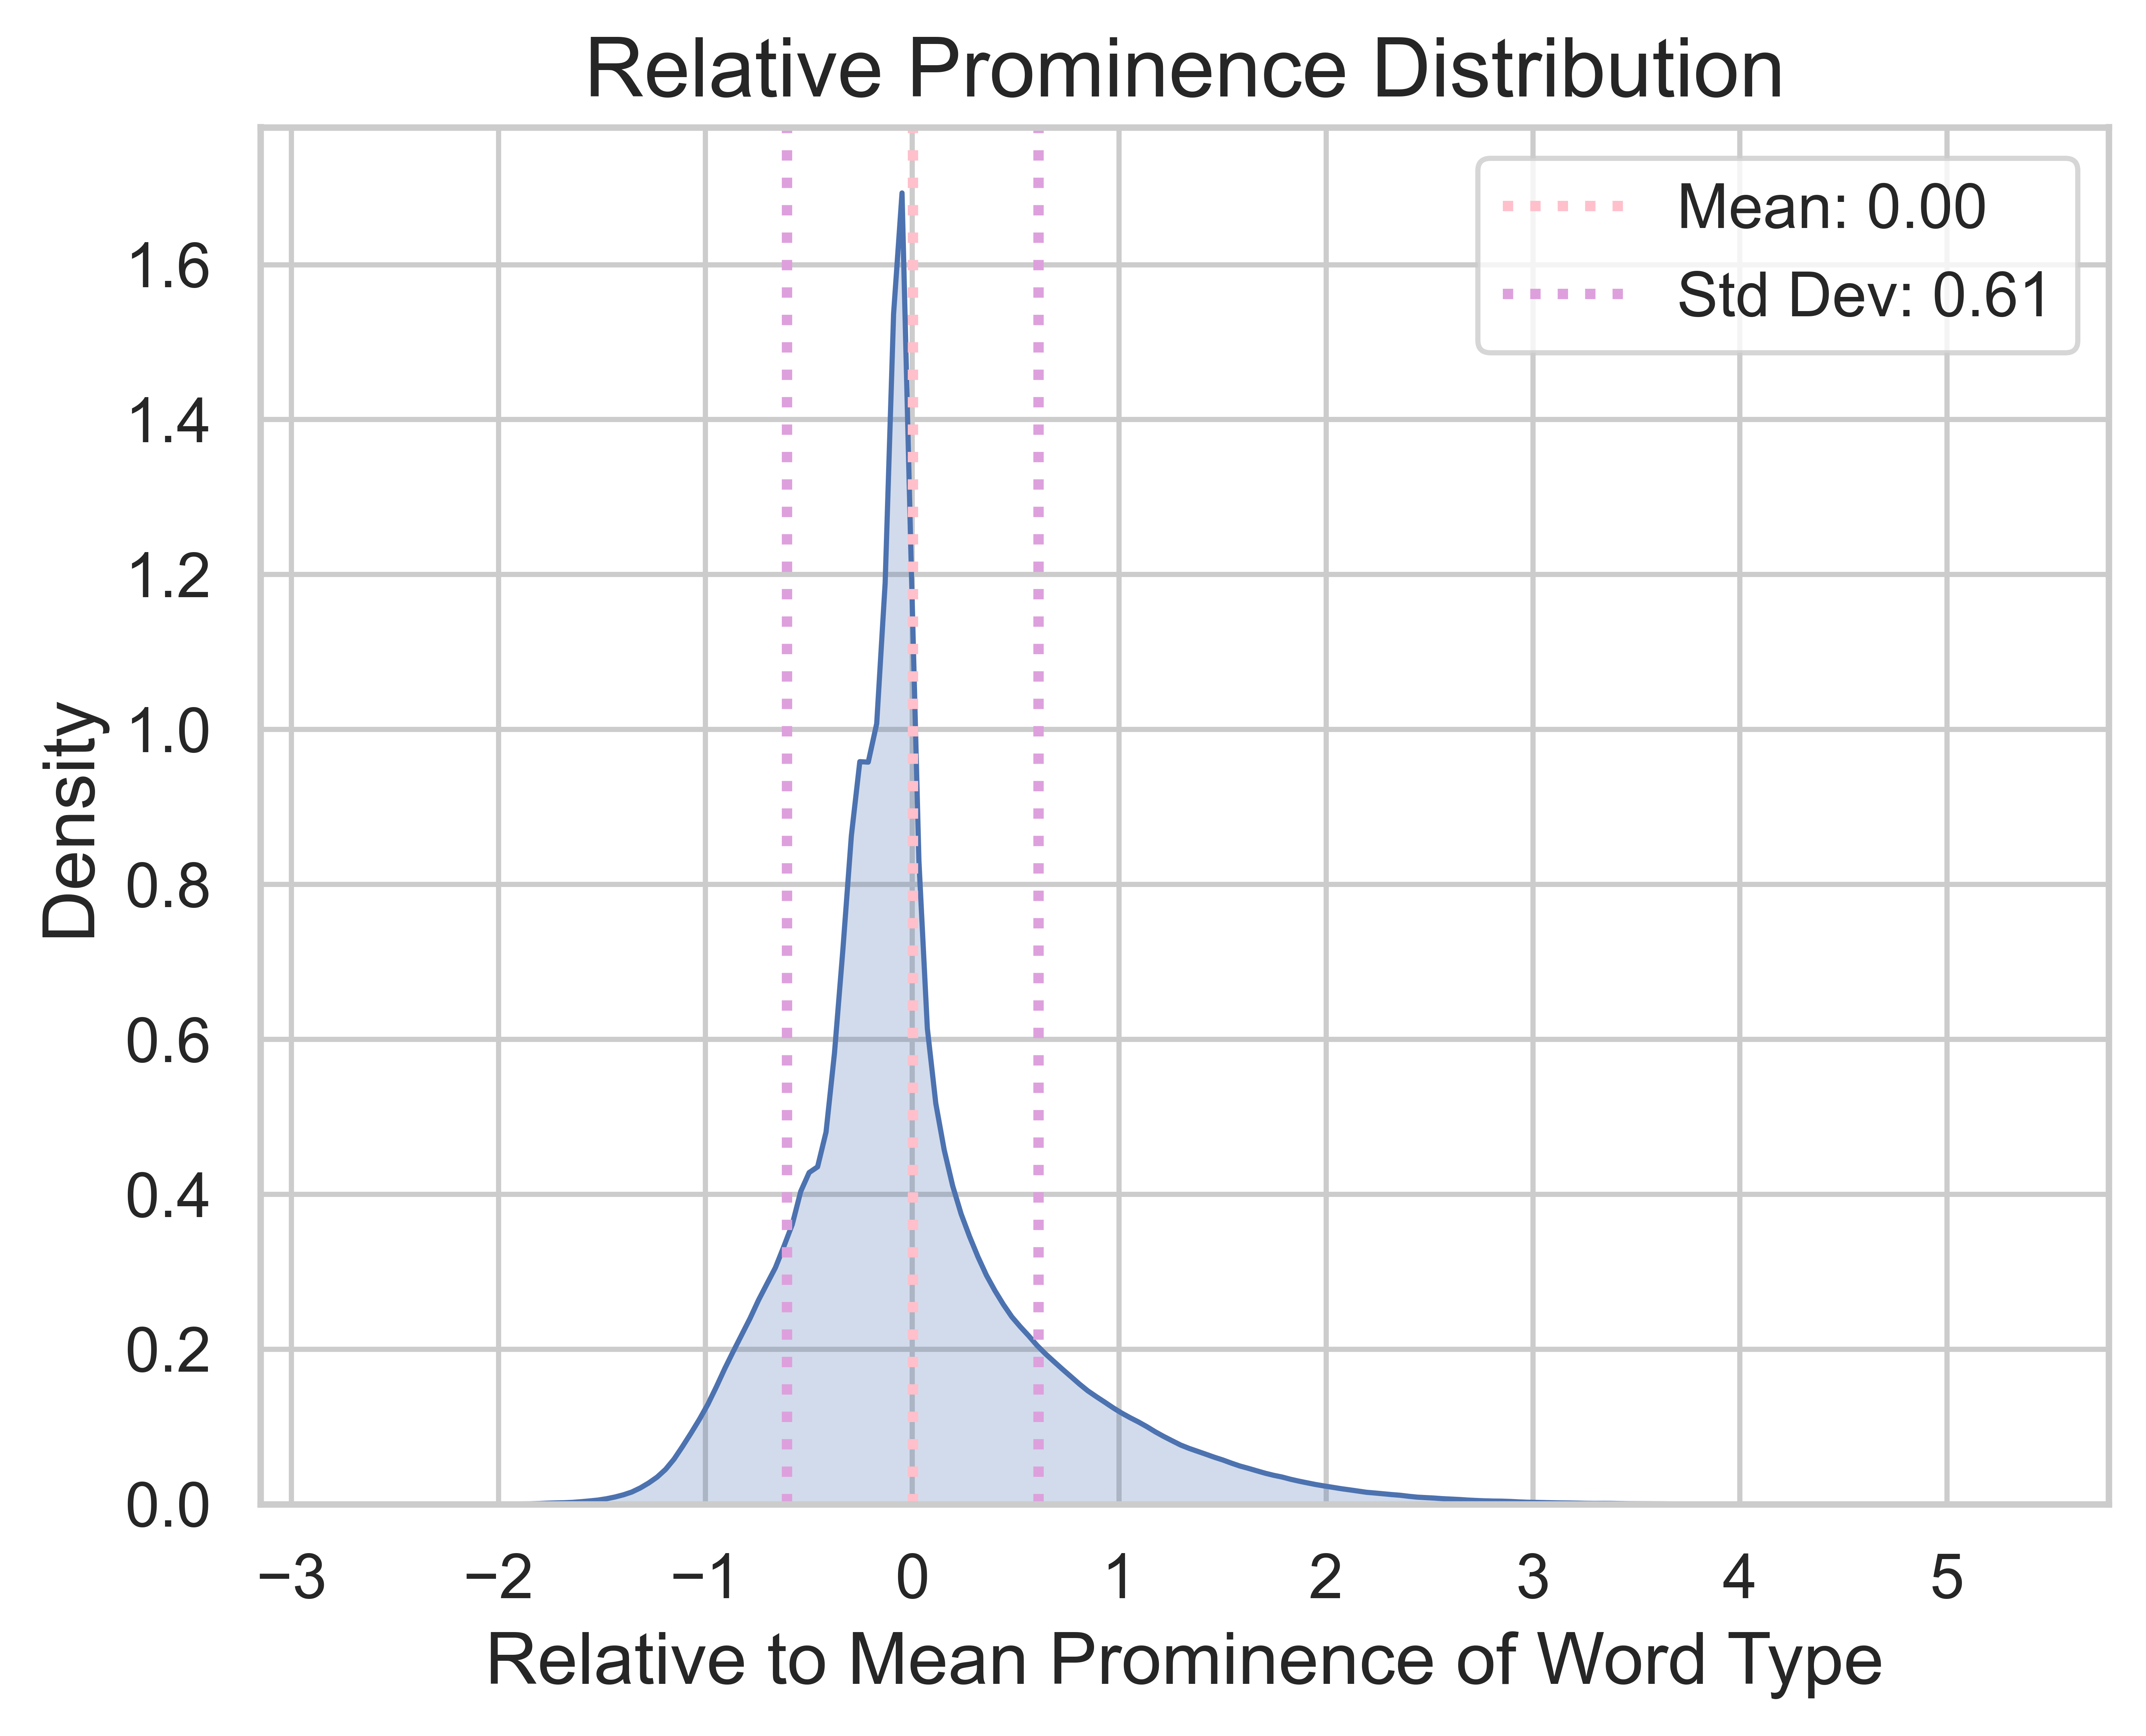

In [20]:
from src.utils.plots import plot_kde

# labels_non_nan = [p for ps in all_train_labels for p in ps if p]

plot_kde(
    all_train_labels,
    bw_adjust=1.0,
    label_name="Relative to Mean Prominence of Word Type",
    title="Relative Prominence Distribution",
)

### Kernel density estimation and Differential Entropy Computation

In [27]:
# kernel density estimation
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

density = gaussian_kde(all_train_labels, bw_method=1.0)

# xs = np.linspace(0, 6, 1000)
# plt.plot(xs, density(xs))
# plt.show()

In [29]:
from src.utils.approximation import monte_carlo_diff_entropy

diff_entropy = monte_carlo_diff_entropy(density, all_train_labels, 5000)
diff_entropy

0.9737664935079232

# Baseline Models and Control Functions 

### Avg of all words in corpus

In [17]:
avg_difference = np.mean(
    all_train_labels
)  # Here, train_labels are assumed to be prominences
print(f"Average prominence: {avg_difference}")

# compute mse
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

predictions = [avg_difference] * len(
    all_test_labels
)  # all_test_labels are assumed to be prominences
mse = mean_absolute_error(all_test_labels, predictions)
print(f"Mean absolute error: {mse}")

# compute r2
r2 = r2_score(all_test_labels, predictions)
print(f"R2 score: {r2}")

# compute pearson
pearson = pearsonr(all_test_labels, predictions)
print(f"Pearson correlation: {pearson}")

# store predictions
avg_test_predictions = []
for i in range(len(all_test_words)):
    sentence_predictions = [avg_difference] * len(all_test_words[i].split(" "))
    avg_test_predictions.append(sentence_predictions)

# store predictions
import pickle
import os

SAVE_DIR = "./path/to/save/directory"  # Please specify your directory path
os.makedirs(f"{SAVE_DIR}/avg", exist_ok=True)

with open(f"{SAVE_DIR}/avg/pred_avg.pkl", "wb") as f:
    pickle.dump(avg_test_predictions, f)

# store texts
with open(f"{SAVE_DIR}/avg/texts_avg.pkl", "wb") as f:
    pickle.dump(all_test_words, f)

# store labels
with open(f"{SAVE_DIR}/avg/labels_avg.pkl", "wb") as f:
    pickle.dump(all_test_labels, f)

Average prominence: 0.0029285576519594335
Mean absolute error: 0.4501614584794255
R2 score: -0.0005607954612203425
Pearson correlation: PearsonRResult(statistic=nan, pvalue=nan)


/opt/homebrew/Caskroom/miniforge/base/envs/prosody/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


### Corpus statistics: predict average per word 

In [18]:
# collect the words types and their respective labels
word_prominence = {}
for word, prominence in zip(all_train_words, all_train_labels):
    if word not in word_prominence:
        word_prominence[word] = []
    word_prominence[word].append(prominence)

# compute the average prominence score for each word
word_prominence_avg = {}
for word, prominence in word_prominence.items():
    word_prominence_avg[word] = np.mean(prominence)

# for each word in the test set, get the average prominence score
predictions = []
for word in all_test_words:
    if word in word_prominence_avg:
        predictions.append(word_prominence_avg[word])
    else:
        predictions.append(avg_difference)  # avg_difference needs to be defined

print(f"Length of test set: {len(all_test_labels)}")
print(f"Length of predictions: {len(predictions)}")

# compute mae
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

mse = mean_absolute_error(all_test_labels, predictions)
print(f"Mean absolute error: {mse}")

# compute r2
r2 = r2_score(all_test_labels, predictions)
print(f"R2 score: {r2}")

# compute pearson
pearson = pearsonr(all_test_labels, predictions)
print(f"Pearson correlation: {pearson}")

# store predictions
word_test_predictions = []
for sentence in all_test_words:
    sentence_predictions = [
        word_prominence_avg[word] if word in word_prominence_avg else avg_difference
        for word in sentence.split()
    ]
    word_test_predictions.append(sentence_predictions)

# store predictions
import pickle
import os

SAVE_DIR = "./path/to/save/directory"  # Please specify your directory path
os.makedirs(f"{SAVE_DIR}/wordavg", exist_ok=True)

with open(f"{SAVE_DIR}/wordavg/pred_wordavg.pkl", "wb") as f:
    pickle.dump(word_test_predictions, f)

# store texts
with open(f"{SAVE_DIR}/wordavg/texts_wordavg.pkl", "wb") as f:
    pickle.dump(all_test_words, f)

# store labels
with open(f"{SAVE_DIR}/wordavg/labels_wordavg.pkl", "wb") as f:
    pickle.dump(all_test_labels, f)

Length of test set: 87833
Length of predictions: 87833
Mean absolute error: 0.449481768815615
R2 score: -0.0008508373279521031
Pearson correlation: PearsonRResult(statistic=0.03393105017920558, pvalue=8.403851218160455e-24)


## GloVe Baseline

In [19]:
GLOVE_PATH = "/Users/lukas/Desktop/projects/MIT/data/models/glove/glove.6B.300d.txt"

H_PARAMS = {
    "num_layers": 3,
    "input_size": 300,  # Update this based on the word embedding model
    "hidden_size": 128,
    "num_labels": 1,
    "dropout_probability": 0.1,
    "learning_rate": 0.001,
    "batch_size": 32,
    "max_epochs": 1,
}

In [22]:
from src.models.baselines.control_function import ControlFunction

control_function = ControlFunction(
    word_embedding_type="glove", word_embedding_path=GLOVE_PATH, hparams=H_PARAMS
)

Loading GloVe: 100%|██████████| 400000/400000 [00:16<00:00, 23962.59it/s]


In [24]:
control_function.fit(words=all_train_words, labels=all_train_labels)

Converting 1986962 words to embeddings...


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type         | Params
---------------------------------------
0 | model | MLPRegressor | 55.2 K
---------------------------------------
55.2 K    Trainable params
0         Non-trainable params
55.2 K    Total params
0.221     Total estimated model params size (MB)


Done.
Initialized MLP Regressor
The MLP Regressor has 55169 trainable parameters.
Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

ValueError: not enough values to unpack (expected 2, got 1)

In [ ]:
# store predictions

pred = control_function.predict(all_test_words)
# flatten the pred
pred = [item for sublist in pred for item in sublist]

In [ ]:
# compute mae
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(all_test_labels, pred)
print(f"Mean absolute error: {mae}")

# compute r2
from sklearn.metrics import r2_score

r2 = r2_score(all_test_labels, pred)
print(f"R2 score: {r2}")

# compute pearson
from scipy.stats import pearsonr

pearson = pearsonr(np.array(all_test_labels), pred)
print(f"Pearson correlation: {pearson}")

### Gradient Boosting

In [ ]:
word_embedding_model = control_function.word_embedding_model

In [ ]:
train_embeddings = [word_embedding_model.get_word_embedding(w) for w in all_train_words]
test_embeddings = [word_embedding_model.get_word_embedding(w) for w in all_test_words]

In [ ]:
# sklearn histgrad regressor
from sklearn.ensemble import HistGradientBoostingRegressor

hgb = HistGradientBoostingRegressor(max_iter=500)
hgb.fit(train_embeddings, all_train_labels)

# store predictions
pred = hgb.predict(test_embeddings)

# compute mae
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(all_test_labels, pred)
print(f"Mean absolute error: {mae}")

# compute r2
from sklearn.metrics import r2_score

r2 = r2_score(all_test_labels, pred)
print(f"R2 score: {r2}")

# compute pearson
from scipy.stats import pearsonr

pearson = pearsonr(np.array(all_test_labels), pred)
print(f"Pearson correlation: {pearson}")